In [1]:
# %%file importMag.py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import warnings
# warnings.filterwarnings('ignore') # ignore warnings: only use this once you are sure things are working
from IPython.html.widgets import *
from fatiando import utils, mesher, gridder
import fatiando.gravmag.prism as prism
from scipy.constants import mu_0

from simpegEM.Utils import coordUtils 

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
%matplotlib inline

In [54]:
def definePrism(dx, dy, dz, depth, susc = 1., x0=0.,y0=0., pinc=0., pdec=0., Einc=90., Edec=0., Bigrf=1e-6, Q = 0., rinc = 0., rdec = 0.):
    """
        wrapper on fatiando prism construction
        
        Prism geometry:
            - dx, dy, dz: width, length and height of prism
            - depth : depth to top of prism
            - susc : susceptibility of prism
            - x0, y0 : center of prism in horizontal plane
            - pinc, pdec : inclination and declination of prism
        
        Earth's field:
            - Einc, Edec : inclination and declination of Earth's magnetic field
            - Bigrf : amplitude of earth's field in units of nT
        
        Remnance:
            - Q : oenigsberger ratio
            - Rinc, Rdec : inclination and declination of remnance in block 
        
    """
    Higrf = Bigrf * 1e-9 / mu_0

    x1, x2 = -dx/2. - x0, dx/2. - x0
    y1, y2 = -dy/2. - y0, dy/2. - y0
    z1, z2 = depth, depth + dz
    Mind = susc*Higrf
    rMag = Q*Mind
    
    # This is a bit of a hack: I am putting all of the parameters we will need later in the 'property' dictionary 
    return mesher.Prism(x1, x2, y1, y2, z1, z2,{'magnetization': utils.ang2vec(rMag, rinc-pinc, rdec-pdec),'pinc':pinc,'pdec':pdec,'rinc':rinc,'rdec':rdec,'depth':depth,'Einc':Einc,'Edec':Edec,'Mind':Mind})

In [55]:
# define the survey area
nx, ny = 100,100
surveyArea = (-10., 10., -10., 10.)
z = 0. 
shape = (nx,ny)
xp, yp, zp = gridder.regular(surveyArea,shape, z=z)

In [56]:
def plotObj3D(p,elev,azim):
    
    depth = p.props['depth']
    x1, x2 = p.x1, p.x2
    y1, y2 = p.y1, p.y2
    z1, z2 = p.z1, p.z2
    pinc, pdec = p.props['pinc'], p.props['pdec']
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams.update({'font.size': 13})
    
    ax.set_xlim3d(surveyArea[:2])
    ax.set_ylim3d(surveyArea[2:])
    ax.set_zlim3d(depth+np.array(surveyArea[:2]))

    xpatch = [x1,x1,x2,x2]
    ypatch = [y1,y2,y2,y1]
    zpatch = [z1,z1,z1,z1]
    xyz = coordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],utils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))
    zpatch = [z2,z2,z2,z2]
    xyz = coordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],utils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))
    
    xpatch = [x1,x1,x1,x1]
    ypatch = [y1,y2,y2,y1]
    zpatch = [z1,z1,z2,z2]                                  
    xyz = coordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],utils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))    
    xpatch = [x2,x2,x2,x2]                                 
    xyz = coordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],utils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])])) 
    
    xpatch = [x1,x2,x2,x1]
    ypatch = [y1,y1,y1,y1]
    zpatch = [z1,z1,z2,z2]                                  
    xyz = coordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],utils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])]))   
    ypatch = [y2,y2,y2,y2]                                 
    xyz = coordUtils.rotatePointsFromNormals(np.vstack([xpatch,ypatch,zpatch]).T, np.r_[1., 0., 0.],utils.ang2vec(1.,pinc,pdec),np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.])
    ax.add_collection3d(Poly3DCollection([zip(xyz[:,0], xyz[:,1], xyz[:,2])])) 
    
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_zlabel('Depth (m)')
    ax.plot(xp,yp,z,'.g')

    ax.view_init(elev,azim) 
# plt.show()

# ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b')

<function __main__.<lambda>>

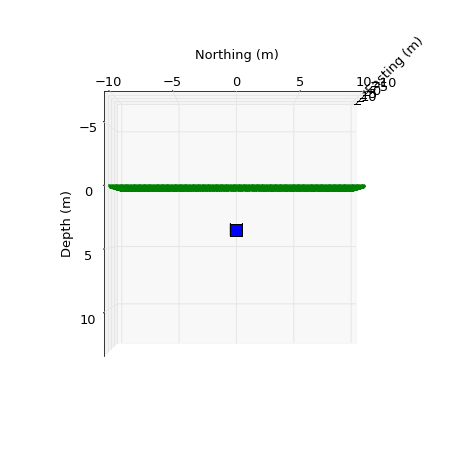

In [57]:
p = definePrism(1., 1., 1., 3., susc = 1., Einc=90., Edec=0., Bigrf=1e-6)

interact(lambda elev, azim: plotObj3D(p,elev,azim),elev=(90.,270.,5.),azim=(-180.,180.,5.))

In [62]:
def getField(p,comp='tf',irt='induced'):
    
    pinc,pdec = p.props['pinc'], p.props['pdec']
    Einc, Edec = p.props['Einc'], p.props['Edec']
    rinc,rdec = p.props['rinc'], p.props['rdec']
    Mind = p.props['Mind']
    
    x1, x2 = p.x1, p.x2
    y1, y2 = p.y1, p.y2
    z1, z2 = p.z1, p.z2
    
    XYZ = np.vstack([xp,yp,zp]).T
    XYZ = coordUtils.rotatePointsFromNormals(XYZ, utils.ang2vec(1., rinc, rdec), np.r_[1.,0.,0.], np.r_[(x1+x2)/2., (y1+y2)/2., (z1+z2)/2.] )

    xp_eval, yp_eval, zp_eval = XYZ[:,0], XYZ[:,1], XYZ[:,2]

    if irt is 'induced' or irt is 'total':
        if comp is 'bx': fieldi = prism.bx(xp_eval,yp_eval,zp_eval,[p],utils.ang2vec(Mind, Einc-pinc, Edec-pdec))
        if comp is 'by': fieldi = prism.by(xp_eval,yp_eval,zp_eval,[p],utils.ang2vec(Mind, Einc-pinc, Edec-pdec))
        if comp is 'bz': fieldi =prism.bz(xp_eval,yp_eval,zp_eval,[p],utils.ang2vec(Mind, Einc-pinc, Edec-pdec))
        if comp is 'tf': fieldi = prism.tf(xp_eval,yp_eval,zp_eval,[p],Einc-pinc,Edec-pdec,utils.ang2vec(Mind, Einc-pinc, Edec-pdec))
            
    if irt is 'remnant' or irt is 'total':
        if comp is 'bx': fieldr = prism.bx(xp_eval,yp_eval,zp_eval,[p])
        elif comp is 'by': fieldr = prism.by(xp_eval,yp_eval,zp_eval,[p])
        elif comp is 'bz': fieldr = prism.bz(xp_eval,yp_eval,zp_eval,zp,[p])
        elif comp is 'tf': fieldr = prism.tf(xp_eval,yp_eval,zp_eval,[p],Einc-Binc,Edec-Bdec)
        
    if irt is 'induced':
        return fieldi
    elif irt is 'remnant':
        return fieldr
    elif irt is 'total':
        return fieldi + fieldr

In [63]:
def plotMag(p, comp='tf'):
    fig,ax = plt.subplots(1,2, figsize = (11, 5))
    plt.rcParams.update({'font.size': 13})

    fieldi = getField(p,comp,'induced')
#     fieldr = getField(p,comp,'remnant')
#     fieldt = fieldi + fieldr
    # fig.canvas.draw()
    im = ax[0].pcolor(xp.reshape(shape),yp.reshape(shape),fieldi.reshape(shape))
    ax[0].axis('equal')
    # ax[0].axis('tight')

    ax[0].set_xlabel('Easting (m)')
    ax[0].set_ylabel('Northing (m)')
    fig.colorbar(im,ax=ax[0],label=comp+' (nT)')

    plotDataPoints = False
    if plotDataPoints:
        ax[0].plot(xp,yp,'.',color='k')

    # plot a line of data
    xline = 0.
    xvec = xp.reshape(shape)[:,0]
    ind = np.min(np.nonzero(abs(xvec - xline) == abs(xvec - xline).min()))
    ax[0].plot(xp.reshape(shape)[ind,:],yp.reshape(shape)[ind,:],'k',linewidth=1.4)

    ax[1].plot(yp.reshape(shape)[ind,:],fieldi.reshape(shape)[ind,:],'o-',markersize=4)
#     ax[1].plot(yp.reshape(shape)[ind,:],fieldr.reshape(shape)[ind,:],'o-',markersize=4)
#     ax[1].plot(yp.reshape(shape)[ind,:],fieldt.reshape(shape)[ind,:],'o-',markersize=4)

    ax[1].grid(which='both')
    ax[1].set_ylabel(comp +' (nT)')
    ax[1].set_xlabel('Northing (m)')
#     ax[1].legend(['induced','remanent','total'],loc='best')

    plt.tight_layout()
    
#     return fig,ax

In [64]:
test = interact(lambda Edec: 'here', Edec = FloatText(value=None))

<function __main__.<lambda>>

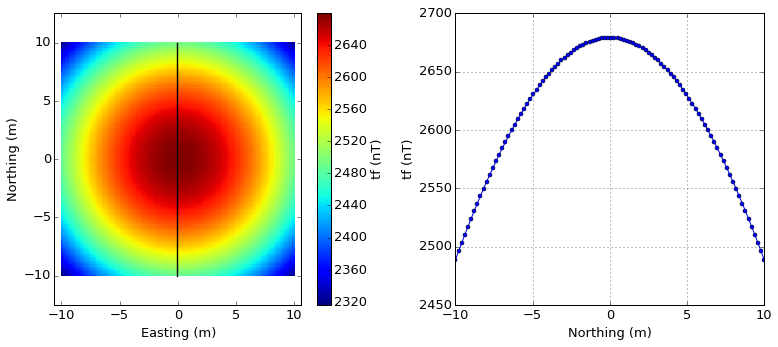

In [66]:
plotMagprsm = lambda dx, dz, depth, susc, Einc, Edec, Bigrf: plotMag(definePrism(dx, dx, dz, depth, susc = susc, Einc= Einc, Edec= Edec, Bigrf=Bigrf))
interact(plotMagprsm, dx = (1e-2,1e1,2e-2), dz = (1.,1e2,1.), depth = (0.,100.,0.1), susc = (0.,200.,1.), Einc = (0.,180.,1.), Edec = (-180.,180.,1.) , Bigrf=(20000., 70000., 100.) )#,comp=['tf','bx','by','bz'] )

In [ ]:
Flo